In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
import torchvision
import torchvision.utils as vutils
import os
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# data_loader
img_size = 32
preprocess_img = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

DATA_DIR = 'data/' # data/faces/xxx.jpg (train dataset)
OUT_DIR = 'CGAN_fake_images'# data/fake_images/xxx.jpg (store the generated pics)

In [3]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
BATCH_SIZE = 128

train_set = MNIST('./mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=BATCH_SIZE)

In [4]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.weight.requires_grad:
            m.weight.data.normal_(std=0.02)
        if m.bias is not None and m.bias.requires_grad:
            m.bias.data.fill_(0)
    elif isinstance(m, nn.BatchNorm2d) and m.affine:
        if m.weight.requires_grad:
            m.weight.data.normal_(1, 0.02)
        if m.bias.requires_grad:
            m.bias.data.fill_(0)

In [5]:
class discriminator_dc(nn.Module):
    def __init__(self):
        super(discriminator_dc, self).__init__()
        self.conv1_1 = nn.Sequential(#input 1x32x32
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
        )# 64 x 16 x 16
        self.conv1_2 = nn.Sequential(#input 10x32x32
            nn.Conv2d(10, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
        )# 64 x 16 x 16
        self.conv2 = nn.Sequential(#input 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )# 256 x 8 x 8
        self.conv3 = nn.Sequential(#input 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )# 512 x 4 x 4
        self.conv5 = nn.Sequential(# 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )# 1 x 1 x 1
        self.apply(init_weights)
        
    def forward(self,x ,label):
        x = self.conv1_1(x)# 64 x 16 x 16
        label = self.conv1_2(label)# 64 x 16 x 16
        x_c = torch.cat((x, label), dim=1)# bs x 128 x 16 x 16
        x_c = self.conv2(x_c)# bs x 256 x 8 x 8
        x_c = self.conv3(x_c)# bs x 512 x 4 x 4
        x = self.conv5(x_c)# bs x 1 x 1 x 1
        return x.view(x.shape[0],-1)


class generator_dc(nn.Module): 
    def __init__(self):
        super(generator_dc, self).__init__()
        self.deconv1_1 = nn.Sequential(# bs x 100 x 1 x 1,
            nn.ConvTranspose2d(100, 256, 4, 1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )# 256 x  4 x 4
        self.deconv1_2 = nn.Sequential(# bs x 10 x 1 x 1,
            nn.ConvTranspose2d(10, 256, 4, 1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )# 256 x  4 x 4
        
        self.conv = nn.Sequential(
            #bs x 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, padding=1),# 256 x  8 x 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, padding=1),# 128 x  16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, padding=1),# 1 x  32 x 32
            nn.Tanh()
        )# bs x 1 x  32 x 32
        self.apply(init_weights)
        
    def forward(self, x , label):
        x = self.deconv1_1(x) # bs x 256 x 4 x 4
        label = self.deconv1_2(label) #bs x 256 x 4 x 4
        x_c = torch.cat((x, label), dim=1)# bs x 512 x 4 x 4
        x = self.conv(x_c) # [b,1,32,32]
        return x

In [6]:
for x,y in train_data:
    #Discriminator
    #real_data = x.view(batch_size, -1).cuda()
    real_data = x.cuda()

    G_label = y.view(-1,1)
    G_label = torch.zeros(BATCH_SIZE, 10).scatter_(1, G_label, 1)
    G_label = G_label.unsqueeze(-1).unsqueeze(-1)# bs,10,1,1
    D_label = G_label.repeat(1,1,img_size,img_size)# bs,10,32,32
    break
    

In [7]:
bce_loss = nn.BCELoss()

def discriminator_loss(real_preds,fake_preds):
    size = real_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    false_labels = torch.zeros(size,1).float().cuda()
    loss = bce_loss(real_preds,true_labels) + bce_loss(fake_preds,false_labels)
    return loss

def generator_loss(fake_preds):
    size = fake_preds.shape[0]
    true_labels = torch.ones(size,1).float().cuda()
    loss = bce_loss(fake_preds,true_labels)
    return loss

def get_adam_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.5, 0.999))
    return optimizer

In [8]:
def train(data_iter,D_net,G_net,D_opt,G_opt,d_loss_func,g_loss_func,noise_size = 100,EPOCH = 10,show_every = 50):
    iter_count = 0
    
    loss = {'d': [], 'g': []}
    
    
    #generate 100 images and each row indicates the same number from 0 to 9
    test_sample_noise = (torch.rand(100, noise_size).unsqueeze(-1).unsqueeze(-1) - 0.5) / 0.5 # -1 ~ 1
    test_fake_inputs = test_sample_noise.cuda() #100,100,1,1

    test_G_label = torch.tensor([[i]*10 for i in range(10)]).view(100,-1)#100,1
    test_G_label = torch.zeros(100, 10).scatter_(1, test_G_label, 1)
    test_G_label = test_G_label.unsqueeze(-1).unsqueeze(-1).cuda()# 100,10,1,1
    
    
    for epoch in range(EPOCH):
        # learning rate decay
        if (epoch+1) == 11:
            G_opt.param_groups[0]['lr'] /= 10
            D_opt.param_groups[0]['lr'] /= 10
            print("learning rate change!")

        if (epoch+1) == 16:
            G_opt.param_groups[0]['lr'] /= 10
            D_opt.param_groups[0]['lr'] /= 10
            print("learning rate change!")
        
        for x,y in data_iter:
            #Discriminator
            #real_data = x.view(batch_size, -1).cuda()
            real_data = x.cuda()
            
            G_label = y.view(-1,1)
            G_label = torch.zeros(x.shape[0], 10).scatter_(1, G_label, 1)
            G_label = G_label.unsqueeze(-1).unsqueeze(-1).cuda()# bs,10,1,1
            D_label = G_label.repeat(1,1,img_size,img_size).cuda()# bs,10,32,32
            
            sample_noise = (torch.rand(x.shape[0], noise_size).unsqueeze(-1).unsqueeze(-1) - 0.5) / 0.5 # -1 ~ 1
            fake_inputs = sample_noise.cuda() #bs,100,1,1
            
            real_preds = D_net(real_data,D_label)#bs,1,32,32
            
            fake_images = G_net(fake_inputs,G_label) 
            fake_preds = D_net(fake_images,D_label)
            
            d_loss = d_loss_func(real_preds,fake_preds)
            
            #optimize discriminator
            D_opt.zero_grad()
            d_loss.backward()
            D_opt.step()

            #generator
            fake_inputs = sample_noise.cuda()
            fake_images = G_net(fake_inputs,G_label) 
            fake_preds = D_net(fake_images,D_label)
            g_loss = g_loss_func(fake_preds)
            #optimize generator
            G_opt.zero_grad()
            g_loss.backward()
            G_opt.step()
            
            loss['d'].append(d_loss.cpu().data.numpy())
            loss['g'].append(g_loss.cpu().data.numpy())
            
            if (iter_count % show_every == 0):
                print('Epoch: {},Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count, d_loss.cpu().data.numpy(), g_loss.cpu().data.numpy()))
            iter_count += 1
            
            
            
            
        generated_image = G_net(test_fake_inputs,test_G_label)
        vutils.save_image(generated_image.data.cpu(),
                  '%s/fake_samples_epoch_%03d.png' % (os.path.join(DATA_DIR, OUT_DIR), epoch),
                  normalize=True,nrow = 10)
 
        #torch.save(G_net.state_dict(), '%s/netG_%03d.pth' % (DATA_DIR, epoch))
        #torch.save(D_net.state_dict(), '%s/netD_%03d.pth' % (DATA_DIR, epoch))

    # plot the loss function versus number of iterations
    plt.plot(loss['d'], label='Discriminator')
    plt.plot(loss['g'], label='Generator')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join(DATA_DIR, OUT_DIR,'Loss.jpg'))
    plt.show()

Epoch: 0,Iter: 0, D: 1.623, G:3.382
Epoch: 0,Iter: 250, D: 1.121, G:2.123
Epoch: 1,Iter: 500, D: 1.016, G:1.558
Epoch: 1,Iter: 750, D: 1.216, G:1.113
Epoch: 2,Iter: 1000, D: 1.035, G:1.279
Epoch: 2,Iter: 1250, D: 1.199, G:1.239
Epoch: 3,Iter: 1500, D: 1.038, G:0.9586
Epoch: 3,Iter: 1750, D: 1.793, G:0.3319
Epoch: 4,Iter: 2000, D: 1.215, G:0.5661
Epoch: 4,Iter: 2250, D: 1.054, G:0.8308
Epoch: 5,Iter: 2500, D: 1.111, G:1.888
Epoch: 5,Iter: 2750, D: 1.212, G:2.344
Epoch: 6,Iter: 3000, D: 0.9431, G:1.163
Epoch: 6,Iter: 3250, D: 1.01, G:2.209
Epoch: 7,Iter: 3500, D: 0.8223, G:1.854
Epoch: 7,Iter: 3750, D: 0.9819, G:3.364
Epoch: 8,Iter: 4000, D: 0.7516, G:1.21
Epoch: 9,Iter: 4250, D: 1.016, G:2.67
Epoch: 9,Iter: 4500, D: 0.8614, G:2.642
learning rate change!
Epoch: 10,Iter: 4750, D: 0.4834, G:1.645
Epoch: 10,Iter: 5000, D: 0.5513, G:1.803
Epoch: 11,Iter: 5250, D: 0.4758, G:1.748
Epoch: 11,Iter: 5500, D: 0.5319, G:1.6
Epoch: 12,Iter: 5750, D: 0.4923, G:1.731
Epoch: 12,Iter: 6000, D: 0.3843, G

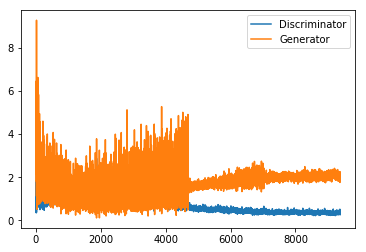

In [9]:
D = discriminator_dc().cuda()
G = generator_dc().cuda()

D_optim = get_adam_optimizer(D)
G_optim = get_adam_optimizer(G)

train(train_data,D, G, D_optim, G_optim, discriminator_loss, generator_loss,noise_size = NOISE_DIM,EPOCH = 20,show_every = 250)

In [10]:
#generate gif
from imageio import imread, imsave, mimsave
images = []
filenames=sorted((fn for fn in os.listdir(os.path.join(DATA_DIR, OUT_DIR)) if fn.endswith('.png')))
for filename in filenames:
    images.append(imread(os.path.join(DATA_DIR, OUT_DIR,filename)))
    
mimsave(os.path.join(DATA_DIR, OUT_DIR, 'samples.gif'), images, fps=10,duration=0.5)